<a href="https://colab.research.google.com/github/maidacundo/DeepLearningREPO/blob/main/Soluzione2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf 
import random
from cv2 import GaussianBlur
import numpy as np

import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, Dense, MaxPooling2D, Add, Dropout, ConvLSTM2D, GaussianNoise, BatchNormalization , Activation, UpSampling2D, Resizing, UpSampling3D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def getDataset():
  (x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()
  normalize = lambda x: x/x.max()
  x_train = normalize(x_train)
  x_test = normalize(x_test)
  createBlurred = lambda arr: np.array([GaussianBlur(x, (5,5), ((random.random()*3)+1)) + (0.02*np.random.normal(0,1, (32, 32, 3))) for x in arr])
  return (createBlurred(x_train), x_train), (createBlurred(x_test), x_test)

In [3]:
(x_train_blured, x_train), (x_test_blured, x_test) = getDataset()
print(f"Train size: {x_train_blured.shape}. Test size: {x_test_blured.shape}")

170508288/170498071 [==============================] - 11s 0us/step
Train size: (50000, 32, 32, 3). Test size: (10000, 32, 32, 3)


In [4]:
def res_block(x, filter, kernel_size, name):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, kernel_size, padding = 'same')(x)
    # x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, kernel_size, padding = 'same')(x)
    # x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu', name=name)(x)
    return x

In [5]:
def dense_block(x, filters, kernel_size, layers):
  layers_connections = []
  layers_connections.append(x)
  for i in range(layers):
    cat = sum(layers_connections)
    x = res_block(cat, filters,kernel_size)
    layers_connections.append(x)
  x = tf.keras.layers.Add()([x, cat])
  return x

In [6]:
input_shape = (32, 32, 3)
inputs = Input(shape=input_shape)

scale_factor = 0.5
n_levels = 3

n, h, w, c = inputs.get_shape().as_list()

for i in range(n_levels):
  scale = scale_factor ** (n_levels - i - 1)
  hi = int(round(h * scale))
  wi = int(round(w * scale))
  print(f'{hi}-{wi}')

8-8
16-16
32-32


In [7]:
0.5 ** (3 - 1 - 1)

0.5

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Layer, Conv2D, Conv2DTranspose, Add, ELU, ReLU,
                                     BatchNormalization, Activation)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import logcosh
import typing


def encode(in_layer: Layer,
           num_layers: int = 15,
           filters: int = 16,
           kernel_size: int = 3,
           strides: int = 1,
           padding: str = 'same',
           use_elu: bool = True,
           bn_before_act: bool = False,
           mult=4,
           use_mult=False,
           layer = 1) -> typing.List[Layer]:
    if not use_mult:
      mult = 1
    layers = []
    x = in_layer
    for i in range(num_layers):
      print(filters*mult)
      x = Conv2D(filters=filters*mult,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding=padding,
                  name='encode_conv{:d}_layer_{:d}'.format(i, layer))(x)
      x = res_block(x, filters*mult,kernel_size, name='encode_conv{:d}_res_1_layer_{:d}'.format(i, layer))
      x = res_block(x, filters*mult,kernel_size, name='encode_conv{:d}_res_2_layer_{:d}'.format(i, layer))
      x = res_block(x, filters*mult,kernel_size, name='encode_conv{:d}_res_3_layer_{:d}'.format(i, layer))
      layers.append(x)

      if i % 2 != 0 and use_mult:
        mult = mult//2
    return layers


def decode(res_layers: typing.List[Layer],
           num_layers: int = 15,
           filters: int = 16,
           kernel_size: int = 3,
           strides: int = 1,
           padding: str = 'same',
           use_elu: bool = True,
           bn_before_act: bool = False,
           mult=1,
           use_mult=False,
           layer = 1) -> typing.List[Layer]:
    if not use_mult:
      mult = 1
    layers = []
    res_layers.reverse()
    x = res_layers[0]
    for i in range(num_layers):
      if i % 2 != 0 and use_mult:
        mult = mult*2
      print(filters*mult)
      x = Conv2DTranspose(filters=filters*mult,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding=padding,
                  name='decode_conv{:d}_layer_{:d}'.format(i, layer))(x)
      x = Add(name='decode_skip{:d}_layer_{:d}'.format(i, layer))([x, res_layers[i]])
      x = res_block(x, filters*mult,kernel_size, name='decode_conv{:d}_res_1_layer_{:d}'.format(i, layer))
      x = res_block(x, filters*mult,kernel_size, name='decode_conv{:d}_res_2_layer_{:d}'.format(i, layer))
      x = res_block(x, filters*mult,kernel_size, name='decode_conv{:d}_res_3_layer_{:d}'.format(i, layer))
      layers.append(x)

    return layers


In [10]:
input_shape = (32, 32, 3)
num_layers = 5
input_img = Input(input_shape)

scale_factor = 0.5
n_levels = 1
n, h, w, c = input_img.get_shape().as_list()

output_pred = input_img
for i in range(n_levels):
  scale = scale_factor ** (n_levels - i - 1)
  hi = int(round(h * scale))
  wi = int(round(w * scale))
  print(f'{hi}-{wi}')
  
  if i == 0:
    input_blured = MaxPooling2D((int(1//scale), int(1//scale))) (input_img)
    input_pred = MaxPooling2D((int(1//scale), int(1//scale))) (output_pred)
  if i == 1:
    input_blured = MaxPooling2D(2, 2) (input_img)
    input_pred = UpSampling2D((int(1//scale), int(1//scale))) (output_pred)
  if i == 2:
    input_blured = input_img
    input_pred = UpSampling2D((2, 2)) (output_pred)
  print(input_blured)
  print(input_pred)

  input_concat = tf.concat([input_pred, input_blured], axis=3, name='inp')

  #ENCODER
  encode_layers = encode(input_concat, num_layers=num_layers, filters=64, layer=i)
  # DECODER
  decode_layers = decode(encode_layers, num_layers=num_layers, filters=64, layer=i)

  output_pred = Conv2DTranspose(filters=3,
                            kernel_size=1,
                            strides=1,
                            padding='same',
                            name='output_conv_layer_{:d}'.format(i))(decode_layers[-1])
  
output = Add(name='output_skip_layer_{:d}'.format(i))([output_pred, input_blured])
output_pred = ELU(name='output_elu_layer_{:d}'.format(i))(output)

model = Model(inputs=input_img, outputs=output_pred)
model.summary()

32-32
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), name='max_pooling2d_2/MaxPool:0', description="created by layer 'max_pooling2d_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), name='max_pooling2d_3/MaxPool:0', description="created by layer 'max_pooling2d_3'")
64
64
64
64
64
64
64
64
64
64
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 32, 32, 3)   0           ['input_3[0][0]']                
                                                                                                  
 max_pool

In [11]:
model.compile(loss='mse', optimizer='adam',metrics=['acc'])

hist = model.fit(x_train_blured.reshape(-1, 32, 32, 3), 
          x_train.reshape(-1, 32, 32, 3), 
          epochs=20, 
          batch_size=34,
          validation_data=(x_test_blured, x_test))

Epoch 1/20
 466/1471 [========>.....................] - ETA: 1:23 - loss: 0.0593 - acc: 0.7664

KeyboardInterrupt: ignored

In [ ]:
# modello

# input
input_shape = (32, 32, 3)
inputs = Input(shape=input_shape)

ngf = 16
mult = 1

inverso = False

scale_factor = 0.5
n_levels = 3

n, h, w, c = inputs.get_shape().as_list()

input_pred = inputs

for i in range(n_levels):

  scale = scale_factor ** (n_levels - i - 1)
  hi = int(round(h * scale))
  wi = int(round(w * scale))
  print(f'{hi}-{wi}')
  
  input_blured = Resizing(hi, wi) (inputs)
  input_pred = Resizing(hi, wi) (input_pred)

  # upsampling


  input_all = tf.concat([input_pred, input_blured], axis=3, name='inp')

  x = Conv2D(ngf*mult, (2, 2), strides = 1, padding = 'same') (input_all)
  x = res_block(x, ngf*mult,(2, 2))
  x = res_block(x, ngf*mult,(2, 2))
  conv_1 = res_block(x, ngf*mult,(2, 2))

  if inverso:
    mult = mult/2
  else:
    mult = mult*2

  x = Conv2D(ngf*mult, (2, 2), strides = 1, padding = 'same') (conv_1)
  x = res_block(x, ngf*mult,(2, 2))
  x = res_block(x, ngf*mult,(2, 2))
  x = res_block(x, ngf*mult,(2, 2))

  conv_2 = MaxPooling2D((2, 2), strides = 2, padding='same') (x)

  if inverso:
    mult = mult/2
  else:
    mult = mult*2

  x = Conv2D(ngf*mult, (2, 2), strides = 1, padding = 'same') (conv_2)
  x = res_block(x, ngf*mult,(2, 2))
  x = res_block(x, ngf*mult,(2, 2))
  conv_3 = res_block(x, ngf*mult,(2, 2))

  # hidden layer
  x = Conv2D(ngf*mult, (3, 3), strides = 1, padding = 'same') (x)
  # x = dense_block(x, ngf*mult, (3, 3), 5)
  # x = Conv2D(ngf*mult, (3, 3), strides = 1, padding = 'same') (x)
  # x = dense_block(x, ngf*mult, (3, 3), 5)
  #x = Conv2D(ngf*mult, (3, 3), strides = 1, padding = 'same') (x)

  # deconvolution

  cat_0 = x + conv_3

  x = res_block(cat_0, ngf*mult,(2, 2))
  x = res_block(x, ngf*mult,(2, 2))
  x = res_block(x, ngf*mult,(2, 2))

  if inverso:
    mult = mult*2
  else:
    mult = mult/2

  x = Conv2DTranspose(ngf*mult, (2, 2), strides = 1, padding = 'same') (x)

  cat_1 = UpSampling2D((2,2)) (x + conv_2)

  x = res_block(cat_1, ngf*mult,(2, 2))
  x = res_block(x, ngf*mult,(2, 2))
  x = res_block(x, ngf*mult,(2, 2))

  if inverso:
    mult = mult*2
  else:
    mult = mult/2

  x = Conv2DTranspose(ngf*mult, (3, 3), strides = 1, padding = 'same') (x)

  # transpose here
  cat_2 = x + conv_1

  x = res_block(cat_2, ngf*mult,(2, 2))
  x = res_block(x, ngf*mult,(2, 2))
  x = res_block(x, ngf*mult,(2, 2))

  # max pooling

  #x = Conv2DTranspose(32, (2, 2), strides = 1, padding = 'same') (x)
  #x = Conv2DTranspose(16, (2, 2), strides = 1, padding = 'same') (x)

  input_pred = Conv2DTranspose(3, (1, 1), strides = 1, activation = 'sigmoid', padding = 'same') (x)

  if i != n_levels - 1:
    input_pred = UpSampling2D((2,2)) (input_pred)

outputs = input_pred

8-8
KerasTensor(type_spec=TensorSpec(shape=(None, 4, 4, 64), dtype=tf.float32, name=None), name='tf.compat.v1.squeeze_5/Squeeze:0', description="created by layer 'tf.compat.v1.squeeze_5'")
16-16


TypeError: ignored

In [ ]:
model = Model(inputs=inputs,outputs=outputs)
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 resizing_39 (Resizing)         (None, 8, 8, 3)      0           ['input_24[0][0]']               
                                                                                                  
 resizing_38 (Resizing)         (None, 8, 8, 3)      0           ['input_24[0][0]']               
                                                                                                  
 tf.concat_18 (TFOpLambda)      (None, 8, 8, 6)      0           ['resizing_39[0][0]',            
                                                                  'resizing_38[0][0]']      

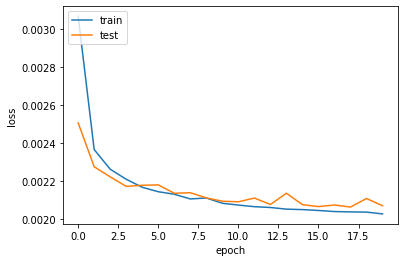

In [ ]:
def plot_history(model_history,keys):
    m,val_m = keys
    plt.plot(model_history.history[m])
    plt.plot(model_history.history[val_m])
    plt.ylabel(m)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

plot_history(hist,['loss','val_loss'])

In [ ]:
from tensorflow.keras.losses import MeanSquaredError

y_true = x_test
y_pred = model.predict(x_test_blured)

mse = MeanSquaredError()
mse(y_true, y_pred).numpy()

#0.0023

#0.0041738243220982366
#0.004219622105503972
#0.00404854369862134
#0.003909846398674108
#0.00379532259022029
#0.003393252
#0.0026358136

0.0020713543

In [ ]:
#utility function to pick samples to be tested

def get_samples(arr, n):
    temp = random.sample(range(len(arr)), n)
    result = arr[temp]
    return result, temp

num = 3
figsize = 15
org, temp = get_samples(x_test, num)
blur = x_test_blured[temp]
preds = model.predict(blur.reshape(-1, 32, 32, 3))
#plotting results
plt.figure(figsize = (figsize, figsize))
print('Original Images')
for i in range(num):
    plt.subplot(1, num, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(org[i])
plt.show()
plt.figure(figsize = (figsize, figsize))
print('Blurred Images')
for i in range(num):
    plt.subplot(1, num, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(blur[i])
plt.show()
plt.figure(figsize = (figsize, figsize))
print('Predicted Images')
for i in range(num):
    plt.subplot(1, num, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(preds[i])
plt.show()

In [ ]:
def rl_standard(raw_image, psf, niter):
    """ Standerd lucy-richardson convolution
    arXiv 2002 Lauer
    """
   
    psf /= psf.sum()
    psf_inverse = psf[::-1]
    lucy = np.ones( raw_image.shape ) * raw_image.mean()

    for i in xrange( niter ):
        estimate = convolve(lucy, psf, mode='mirror')
        estimate[ np.isnan(estimate) ] = 0

        correction = convolve(raw_image/estimate, psf_inverse, mode='mirror')
        correction[ np.isnan(correction) ] = 0
        print 'Correction:',correction.mean()
        
        lucy *= correction
        print 'Means:', raw_image.mean(), lucy.mean()
        chisq = scipy.nansum((lucy - raw_image)**2 / (lucy)) / (raw_image.size-1)
        print chisq

    return lucy

In [ ]:
from keras.layers import Input
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D
from keras.layers.core import Dense, Flatten
from keras.layers import BatchNormalization
from keras.models import Model


from keras.layers import Input, Activation, Add
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.core import Lambda
from keras.models import Model

ndf = 64
ngf = 64
n_blocks_gen = 9
output_nc = 3
input_shape_discriminator = (32, 32, output_nc)

inputs = Input(shape=(32, 32, 3))

x = Conv2D(filters=ngf, kernel_size=(2,2), padding='valid')(inputs)
# x = BatchNormalization()(x)
x = Activation('relu')(x)
print(x)
# Increase filter number
n_downsampling = 2
for i in range(n_downsampling):
    mult = 2**i
    x = Conv2D(filters=ngf*mult*2, kernel_size=(3,3), strides=2, padding='same')(x)
    print(x)
    # x = BatchNormalization()(x)
    x = Activation('relu')(x)

# Apply 9 ResNet blocks
mult = 2**n_downsampling
for i in range(n_blocks_gen):
    x = res_block(x, ngf*mult, (2, 2))

# Decrease filter number to 3 (RGB)
for i in range(n_downsampling):
    mult = 2**(n_downsampling - i)
    x = Conv2DTranspose(filters=int(ngf * mult / 2), kernel_size=(2, 2), strides=2-i, padding='same')(x)
    # x = BatchNormalization()(x)
    x = Activation('relu')(x)

x = Conv2DTranspose(filters=32, kernel_size=(2, 2), strides=2, padding='same')(x)

x = Conv2D(filters=32, kernel_size=(3,3), padding='same')(x)
x = Conv2D(filters=64, kernel_size=(2,2), padding='same')(x)
x = Conv2D(filters=output_nc, kernel_size=(1,1), padding='same')(x)

x = Activation('tanh')(x)

# Add direct connection from input to output and recenter to [-1, 1]
# outputs = Add()([x, inputs])
# outputs = Lambda(lambda z: z/2)(x)
# print(outputs)
x = Conv2D(8, (2, 2), strides = 1, padding = 'same') (x)
#decode
x = Conv2DTranspose(16, (2, 2), strides = 1, padding = 'same') (x)
x = Conv2DTranspose(32, (2, 2), strides = 1, padding = 'same') (x)
x = Conv2DTranspose(64, (2, 2), strides = 1, padding = 'same') (x)
outputs = Conv2DTranspose(3, (1, 1), strides = 1, activation = 'sigmoid', padding = 'same') (x)
model = Model(inputs=inputs, outputs=outputs, name='Generator')
model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 31, 31, 64), dtype=tf.float32, name=None), name='activation_24/Relu:0', description="created by layer 'activation_24'")
KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 128), dtype=tf.float32, name=None), name='conv2d_25/BiasAdd:0', description="created by layer 'conv2d_25'")
KerasTensor(type_spec=TensorSpec(shape=(None, 8, 8, 256), dtype=tf.float32, name=None), name='conv2d_26/BiasAdd:0', description="created by layer 'conv2d_26'")
Model: "Generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_24 (Conv2D)             (None, 31, 31, 64)   832         ['input_2[0][0]']               